In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Machine learning libraries
import keras
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation, Concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split


# Computer vision libraries
import cv2
import imghdr

# Image processing library
from PIL import Image

# Other
from glob import glob

# File libraries
import os
import pickle

### GPU stuff

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)

if physical_devices:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

### Specify directories

In [4]:
X_dir = 'Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter/images'
y_dir = 'Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter/maskpngs'

X_path = 'Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter/X'
y_path = 'Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter/y'

### Visualization of data

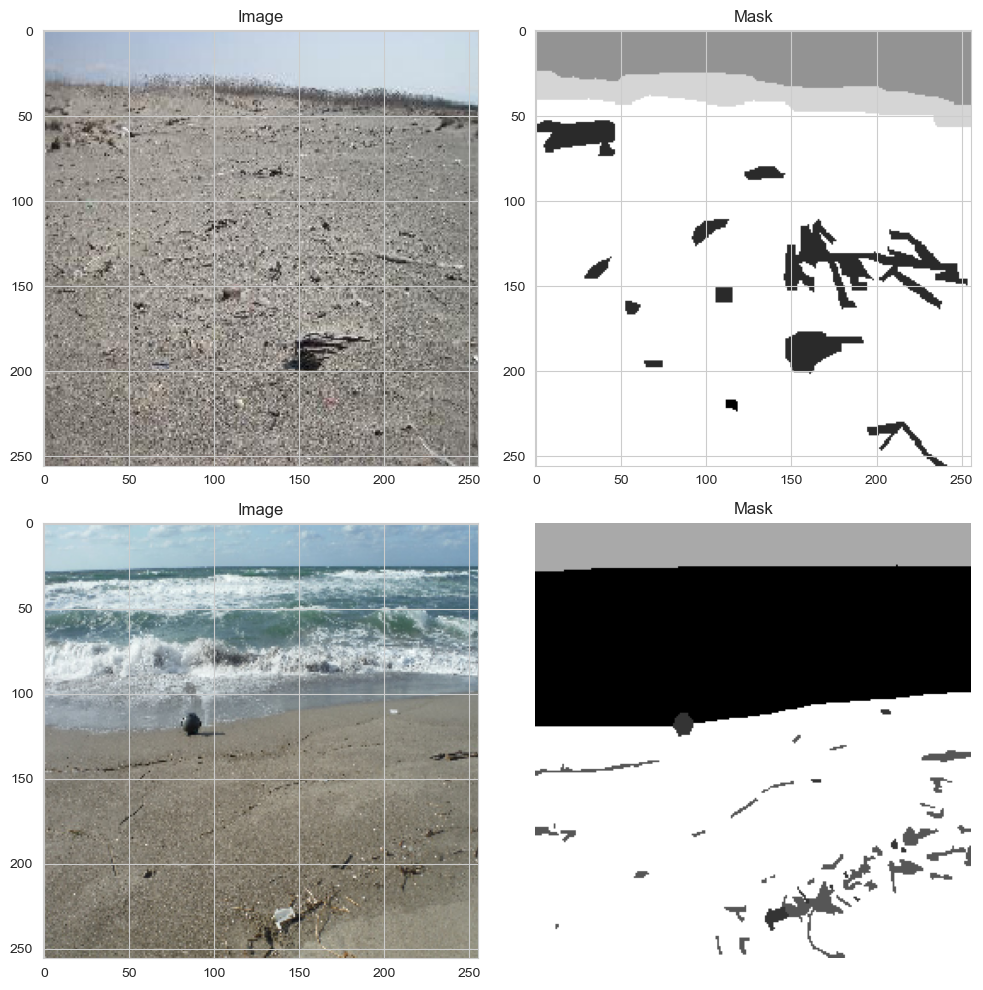

In [5]:
def visualize_data(image_dir, mask_dir, num_examples=2):
    image_files = os.listdir(image_dir)
    mask_files = {os.path.splitext(f)[0]: f for f in os.listdir(mask_dir)}
    
    fig, axes = plt.subplots(num_examples, 2, figsize=(10, num_examples * 5))
    
    for i in range(num_examples):
        img_name = random.choice(image_files)
        img_base_name = os.path.splitext(img_name)[0]
        
        img_path = os.path.join(image_dir, img_name)
        mask_name = mask_files.get(img_base_name, None)
        
        if not mask_name:
            print(f"Mask not found for {img_name}")
            continue
        
        mask_path = os.path.join(mask_dir, mask_name)
        
        image = img_to_array(load_img(img_path, target_size=(256, 256))) / 255.0
        mask = img_to_array(load_img(mask_path, target_size=(256, 256), color_mode='grayscale')) / 255.0
        
        axes[i, 0].imshow(image)
        axes[i, 0].set_title('Image')
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title('Mask')
        
    plt.tight_layout()
    plt.axis('off')
    plt.show()

visualize_data('./Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter/images', './Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter/maskpngs')


# temporary dont run these cells below

### Process images - Research paper states 4:3 aspect ratio for more than 95% of the images, but since NN requires same dimension image, we will sacriface accuracy and use 1:1 aspect ratio and 400 x 400 size

In [ ]:
# Get the list of image and mask file paths
image_paths = sorted(glob(os.path.join(X_dir, '*')))
mask_paths = sorted(glob(os.path.join(y_dir, '*')))

# Ensure the lists are correctly sorted and aligned
assert len(image_paths) == len(mask_paths), "Number of images and masks do not match"

In [ ]:
def load_and_preprocess(image_path, mask_path, num_classes=8):
    with tf.device('/GPU:0'):
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (400, 400))
        img = tf.cast(img, tf.float32) / 255.0
        
        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_png(mask, channels=1)  # Load masks as grayscale
        mask = tf.image.resize(mask, (400, 400))
        mask = tf.cast(mask, tf.uint8)  # Ensure mask is of integer type
        mask = tf.squeeze(mask, axis=-1)  # Remove the last dimension if it is 1
        mask = tf.one_hot(mask, depth=num_classes)  # Convert to one-hot encoding for multi-class segmentation
        
    return img, mask

In [ ]:
# Create datasets from the file paths
image_ds = tf.data.Dataset.from_tensor_slices(image_paths)
mask_ds = tf.data.Dataset.from_tensor_slices(mask_paths)

# Load and preprocess the images and masks
dataset = tf.data.Dataset.zip((image_ds, mask_ds))
dataset = dataset.map(lambda x, y: load_and_preprocess(x, y, 8), num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# Separate images and masks
image_dataset = dataset.map(lambda x, y: x)  # Extract images
mask_dataset = dataset.map(lambda x, y: y)   # Extract masks

In [ ]:
# Split into train and test datasets
train_size = int(0.7 * len(image_paths))  
test_size = len(image_paths) - train_size  

In [ ]:
train_dataset = tf.data.Dataset.zip((image_dataset.take(train_size), mask_dataset.take(train_size))).repeat()
test_dataset = tf.data.Dataset.zip((image_dataset.skip(train_size), mask_dataset.skip(train_size))).repeat()

# Batch and prefetch datasets

BATCH_SIZE = 5
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
# TESTING
for image_batch, mask_batch in train_dataset.take(1):
    print(image_batch.shape)  # Expected: (BATCH_SIZE, 400, 400, 3)
    print(mask_batch.shape)   # Expected: (BATCH_SIZE, 400, 400, 8)

### U-net Neural Network Architecture
#### The U-net architecture is very good at image segmentation and originally developed for biomedical applications, but now can be used for segmenting trash in ocean cleanups!
#### Here we are using the categorical crossentropy loss for multi-segmentation classification

In [ ]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(num_filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    x = Concatenate()([x, skip])
    return x

def unet(input_shape=(400, 400, 3), num_classes=8):
    inputs = Input(input_shape)
    
    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    
    # Bottleneck
    b1 = conv_block(p4, 1024)
    
    # Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    
    # Output
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(d4)  # Adjusted for num_classes
    
    model = Model(inputs, outputs, name='UNET')
    return model

In [ ]:
model = unet((400, 400, 3), num_classes=8) # 8 classes according to the research article
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
type(test_dataset)

In [ ]:
# Train the model
history = model.fit(train_dataset, test_dataset, 
                    batch_size=BATCH_SIZE * 2, 
                    verbose=1, 
                    epochs=2)
                    # steps_per_epoch=len(image_paths) * 0.7 // (BATCH_SIZE * 2),
                    # validation_steps=len(image_paths) * 0.7 // (BATCH_SIZE * 2),


In [ ]:
# Save the model to a file
with open('trained_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
# Display graphs for training
epochs = [i for i in range(5)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
# Define your load_process_small function
def load_process_small(image_path):
    with tf.device('/GPU:0'):  # Adjust device as per your setup
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (400, 400))
        img = tf.cast(img, tf.float32) / 255.0
            
    return img

# Example usage
example_image_path = 'Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter/X/train_000000.jpg'
example_image = load_process_small(example_image_path)

# Assuming your model is already loaded and ready for prediction
# Make predictions
segmentation_mask = model.predict(np.expand_dims(example_image, axis=0))[0]

# Visualize the results
plt.figure(figsize=(15, 5))

# Show the original image
plt.subplot(1, 4, 1)
plt.imshow(example_image)
plt.title('Original Image')

# Show the segmentation mask (argmax for grayscale visualization)
segmentation_mask_gray = np.argmax(segmentation_mask, axis=-1)
plt.subplot(1, 4, 2)
plt.imshow(segmentation_mask_gray, cmap='gray')  # Adjust the colormap as needed
plt.title('Segmentation Mask (Grayscale)')

# Optionally, visualize each class separately
for i in range(segmentation_mask.shape[-1], 3):
    plt.subplot(1, 4, i + 3)
    plt.imshow(segmentation_mask[:, :, i], cmap='viridis')  # Adjust the colormap as needed
    plt.title(f'Class {i}')

plt.tight_layout()
plt.show()

# Experimental section

#### Experimental Resizing and cropping images on disk rather than memory

In [6]:
target_width = 400 
target_height = 400

def resize_and_crop(image_path, output_path):
    img = cv2.imread(image_path)
    height, width, _ = img.shape
    aspect_ratio = width / float(height)

    if aspect_ratio > 1:
        new_width = int(target_height * aspect_ratio)
        img = cv2.resize(img, (new_width, target_height), interpolation=cv2.INTER_AREA)
        start = (new_width - target_width) // 2
        img = img[:, start:start + target_width]
    else:
        new_height = int(target_width / aspect_ratio)
        img = cv2.resize(img, (target_width, new_height), interpolation=cv2.INTER_AREA)
        start = (new_height - target_height) // 2
        img = img[start:start + target_height, :]

    cv2.imwrite(output_path, img)

In [7]:
# Iterate over images in X_dir and y_dir, apply resize_and_crop function
for filename in os.listdir(X_dir):
    if filename.endswith(".jpg"):  
        img_path = os.path.join(X_dir, filename)
        output_path = os.path.join(X_path, f"train_{filename}")  # Example output path, adjust as needed
        resize_and_crop(img_path, output_path)

for filename in os.listdir(y_dir):
    if filename.endswith(".png"): 
        img_path = os.path.join(y_dir, filename)
        output_path = os.path.join(y_path, f"test_{filename}")  # Example output path, adjust as needed
        resize_and_crop(img_path, output_path)

#### Normalizing

In [5]:
def load_images_and_masks(image_dir, mask_dir):
    images = []
    masks = []

    with tf.device('/GPU:0'):
        image_files = sorted(os.listdir(image_dir))
        mask_files = sorted(os.listdir(mask_dir))
    
        for image_file, mask_file in zip(image_files, mask_files):
            # Get the image paths
            image_path = os.path.join(image_dir, image_file)
            mask_path = os.path.join(mask_dir, mask_file)
    
            # Load images
            image = load_img(image_path, color_mode='rgb')
            mask = load_img(mask_path, color_mode='rgb')
    
            # Normalize each image
            image = img_to_array(image) / 255.0
            mask = img_to_array(mask) / 255.0
    
            images.append(image)
            masks.append(mask)
    
        # Return array of the normalized images and masks
        return np.array(images), np.array(masks) 

In [6]:
image_array, mask_array = load_images_and_masks(X_path, y_path)

In [7]:
print(f'Image {image_array.shape}')
print(f'Mask {mask_array.shape}')

Image (3500, 400, 400, 3)
Mask (3500, 400, 400, 3)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(image_array, mask_array, test_size=0.1, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

In [9]:
y_train

array([[[[0.2509804 , 0.        , 0.        ],
         [0.2509804 , 0.        , 0.        ],
         [0.2509804 , 0.        , 0.        ],
         ...,
         [0.2509804 , 0.        , 0.        ],
         [0.2509804 , 0.        , 0.        ],
         [0.2509804 , 0.        , 0.        ]],

        [[0.2509804 , 0.        , 0.        ],
         [0.2509804 , 0.        , 0.        ],
         [0.2509804 , 0.        , 0.        ],
         ...,
         [0.2509804 , 0.        , 0.        ],
         [0.2509804 , 0.        , 0.        ],
         [0.2509804 , 0.        , 0.        ]],

        [[0.2509804 , 0.        , 0.        ],
         [0.2509804 , 0.        , 0.        ],
         [0.2509804 , 0.        , 0.        ],
         ...,
         [0.2509804 , 0.        , 0.        ],
         [0.2509804 , 0.        , 0.        ],
         [0.2509804 , 0.        , 0.        ]],

        ...,

        [[0.5019608 , 0.5019608 , 0.        ],
         [0.5019608 , 0.5019608 , 0.        ]

#### temp nn architecture

In [10]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(num_filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    x = Concatenate()([x, skip])
    return x

def unet(input_shape=(400, 400, 3), num_classes=8):
    inputs = Input(input_shape)
    
    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    
    # Bottleneck
    b1 = conv_block(p4, 1024)
    
    # Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    
    # Output
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(d4)  # Adjusted for num_classes
    
    model = Model(inputs, outputs, name='UNET')
    return model

In [11]:
model = unet((400, 400, 3), num_classes=8) # 8 classes according to the research article
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 400, 400, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 400, 400, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

In [12]:
# Train the model
with tf.device('/GPU:0'):
    history = model.fit((X_train,y_train),
        batch_size=2,
        epochs=2,
        verbose=1,
        callbacks=None,
        validation_data=(X_val, y_val),
        shuffle=True,
        steps_per_epoch=1050,
        # validation_steps=None,
        # validation_batch_size=None,
        # validation_freq=1
    )

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

2100.0

Helper code if things break:

In [11]:
# import os
# 
# # Define the directory path
# directory = X_path
# 
# # Iterate over files in the directory
# for filename in os.listdir(directory):
#     if "train" in filename:
#         file_path = os.path.join(directory, filename)
#         try:
#             os.remove(file_path)
#             print(f"Deleted: {file_path}")
#         except OSError as e:
#             print(f"Error deleting {file_path}: {e}")
# 
# directory = y_path
# 
# for filename in os.listdir(directory):
#     if "test" in filename:
#         file_path = os.path.join(directory, filename)
#         try:
#             os.remove(file_path)
#             print(f"Deleted: {file_path}")
#         except OSError as e:
#             print(f"Error deleting {file_path}: {e}")

Deleted: Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter/X\train_000000.jpg
Deleted: Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter/X\train_000001.jpg
Deleted: Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter/X\train_000002.jpg
Deleted: Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter/X\train_000003.jpg
Deleted: Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter/X\train_000004.jpg
Deleted: Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter/X\train_000005.jpg
Deleted: Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter/X\train_000006.jpg
Deleted: Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter/X\train_000007.jpg
Deleted: Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter/X\train_000008.jpg
Deleted: Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter/X\train_000009.jpg
Deleted: Beach Cleanup Dataset/beachlitter_dataset_2022/beachlitter/X\train_000010.jpg
Deleted: Beach Cleanup Dataset/beachlitter_